In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import catboost
import optuna

import eli5
from eli5.sklearn import PermutationImportance

In [3]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/Upstage_ML_Competition01/data/train.csv'
test_path  = '/data/ephemeral/home/Upstage_ML_Competition01/data/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

In [5]:
concat.groupby(by="아파트명")["층"].mean()

아파트명
153-25      2.666667
201호 미공시    2.000000
2차한양        6.648402
3RU-City    7.424242
3차신성미소지움    5.457831
              ...   
힐탑트레져1동     6.795455
힐튼          2.611111
힐튼빌리지1차     3.384615
힐튼빌리지2차     2.714286
힐하우스        2.916667
Name: 층, Length: 6549, dtype: float64

In [5]:
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])

In [6]:
# train1 데이터프레임에서 'name' 열이 결측치인 행 선택
missing_name_rows = concat[concat['아파트명'].isna()]

# 선택된 행들에 대해 '구'+'first_num'+'_'+'second_num'로 결측치 대입
missing_name_rows['아파트명'] = missing_name_rows['동'] + missing_name_rows['본번'].astype(str) + '_' + missing_name_rows['부번'].astype(str)

# 기존 train1에 변경된 행들을 업데이트
concat.update(missing_name_rows)

concat

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712.0,8.0,3.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0.0,강남구,개포동
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712.0,22.0,4.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0.0,강남구,개포동
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712.0,28.0,5.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0.0,강남구,개포동
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801.0,3.0,4.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0.0,강남구,개포동
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801.0,8.0,2.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0.0,강남구,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307.0,19.0,13.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307.0,25.0,12.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308.0,27.0,12.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309.0,2.0,18.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동


In [7]:
# 'city' 열을 공백을 기준으로 분할하여 'gu'와 'dong' 열 생성
concat[['구', '동']] = concat['시군구'].str.split(expand=True)[[1, 2]]

concat

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712.0,8.0,3.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0.0,강남구,개포동
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712.0,22.0,4.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0.0,강남구,개포동
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712.0,28.0,5.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0.0,강남구,개포동
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801.0,3.0,4.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0.0,강남구,개포동
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801.0,8.0,2.0,1987.0,...,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0.0,강남구,개포동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307.0,19.0,13.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307.0,25.0,12.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308.0,27.0,12.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309.0,2.0,18.0,2014.0,...,2015-09-09 15:30:27.0,Y,N,127.10672,37.618870,2014-09-01 13:05:03.0,NaN,1.0,중랑구,신내동


In [8]:
concat.isna().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                            0
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

In [9]:
# 아파트 평균 층수 상위 50개
floor_mean_top50 = train.groupby(by="아파트명")["층", "target"].mean().sort_values(by="층", ascending=False).head(50)
floor_mean_top50

,층,target
아파트명,,
타워팰리스3,41.068182,238899.242424
현대하이페리온,33.613240,178768.989547
타워팰리스1,30.591040,234053.563584
래미안용산더센트럴,29.809524,272525.714286
힐스테이트뉴포레,28.000000,93000.000000
보라매삼성쉐르빌,27.493333,85119.066667
갤러리아포레,27.034653,393042.742574
갤러리아팰리스,26.859416,147553.395225
금천롯데캐슬골드파크3차,26.839623,95607.547170


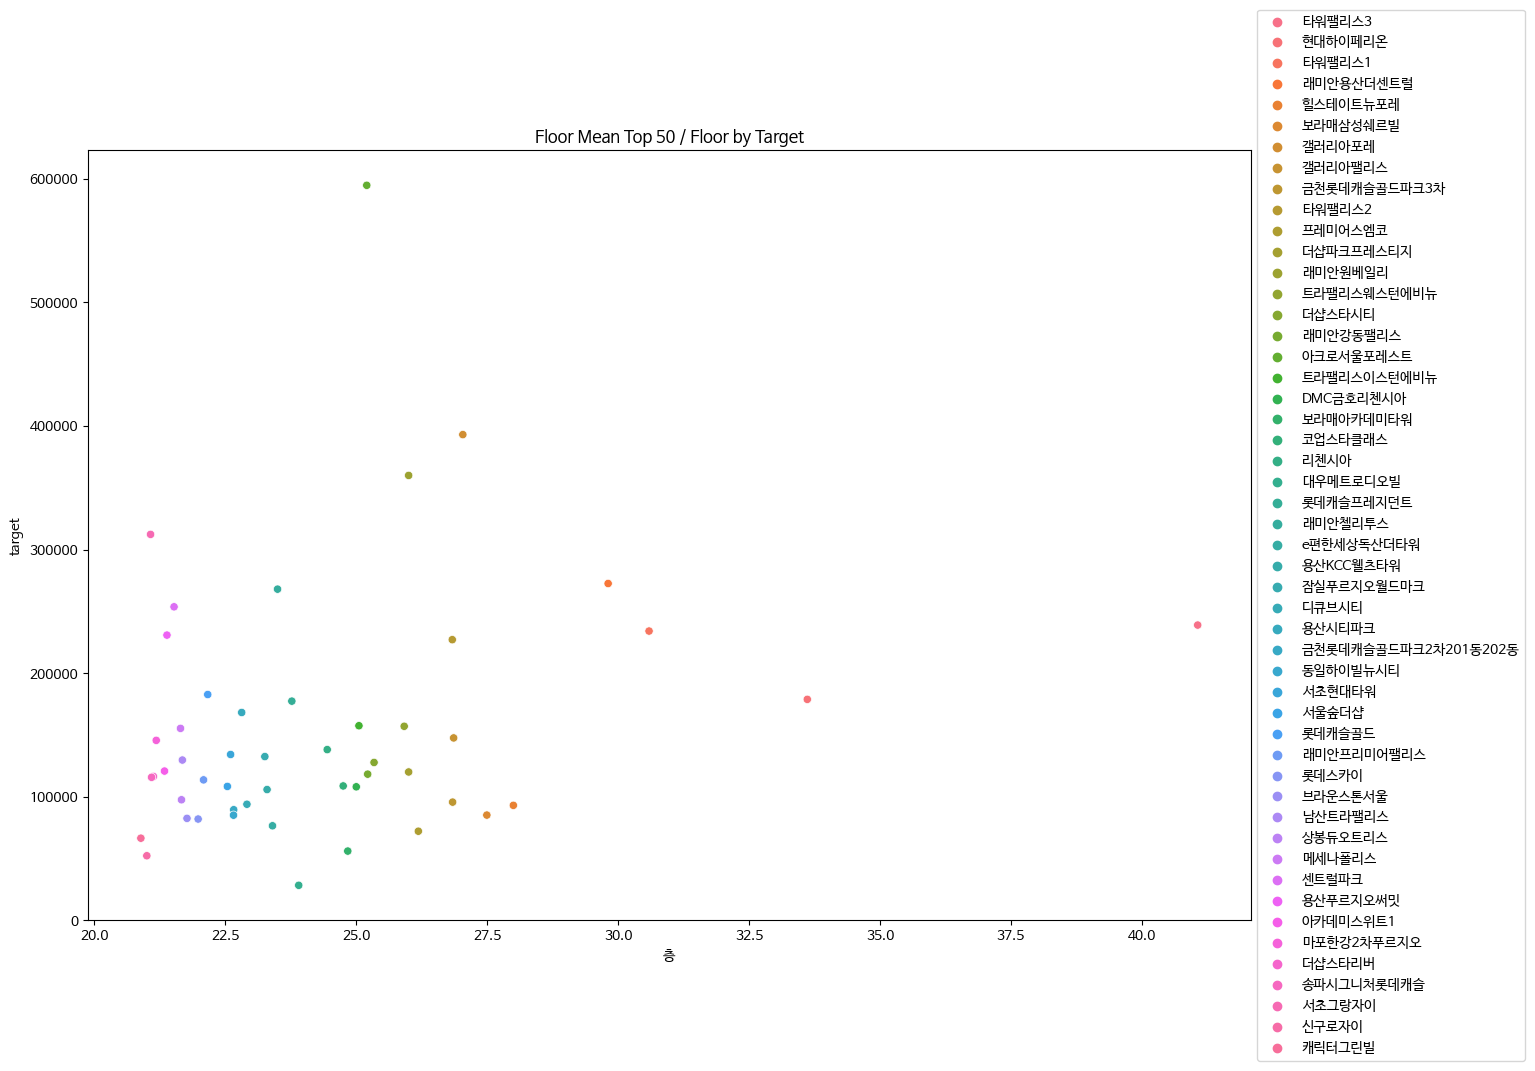

In [10]:
plt.figure(figsize=(15, 10))
plt.title("Floor Mean Top 50 / Floor by Target")
floor_scatter = sns.scatterplot(data=floor_mean_top50, x="층", y="target", hue=floor_mean_top50.index,legend=True)
floor_scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '타워팰리스3'),
  Text(1, 0, '현대하이페리온'),
  Text(2, 0, '타워팰리스1'),
  Text(3, 0, '래미안용산더센트럴'),
  Text(4, 0, '힐스테이트뉴포레'),
  Text(5, 0, '보라매삼성쉐르빌'),
  Text(6, 0, '갤러리아포레'),
  Text(7, 0, '갤러리아팰리스'),
  Text(8, 0, '금천롯데캐슬골드파크3차'),
  Text(9, 0, '타워팰리스2'),
  Text(10, 0, '프레미어스엠코'),
  Text(11, 0, '더샵파크프레스티지'),
  Text(12, 0, '래미안원베일리'),
  Text(13, 0, '트라팰리스웨스턴에비뉴'),
  Text(14, 0, '더샵스타시티'),
  Text(15, 0, '래미안강동팰리스'),
  Text(16, 0, '아크로서울포레스트'),
  Text(17, 0, '트라팰리스이스턴에비뉴'),
  Text(18, 0, 'DMC금호리첸시아'),
  Text(19, 0, '보라매아카데미타워'),
  Text(20, 0, '코업스타클래스'),
  Text(21, 0, '리첸시아'),
  Text(22, 0, '대우메트로디오빌'),
  Text(23, 0, '롯데캐슬프레지던트'),
  Text(24, 0, '래미안첼리투스'),
  Text(25, 0, 'e편한세상독산더타워'),
  Text(26, 0, '용산KCC웰츠타워'),
  Text(27, 0, '잠실푸르지오월드마크'),
  Text(28, 0, '디큐브시티'),
  T

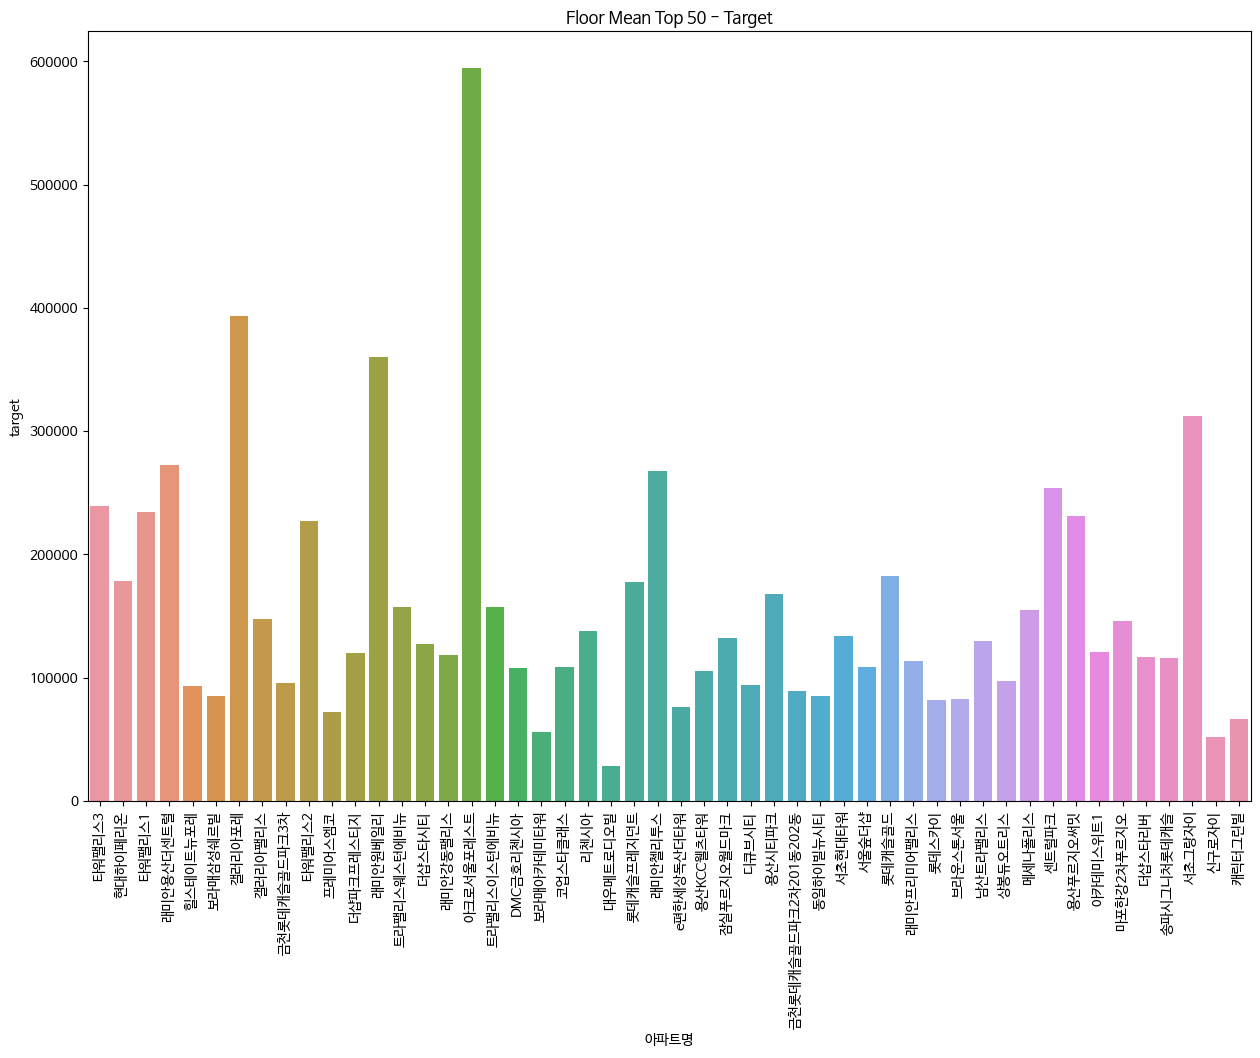

In [11]:
plt.figure(figsize=(15, 10))
plt.title("Floor Mean Top 50 - Target")
floor_scatter = sns.barplot(data=floor_mean_top50, x=floor_mean_top50.index, y="target")
plt.xticks(rotation=90)

In [12]:
# 아파트 평균 층수 하위 50개
floor_mean_buttom50 = train.groupby(by="아파트명")["층", "target"].mean().sort_values(by="층", ascending=False).tail(50)
floor_mean_buttom50

,층,target
아파트명,,
연합파크빌,2.000000,35300.727273
남구로,2.000000,14100.000000
비욘디에,2.000000,90925.000000
대우멤버스카운티301,2.000000,109250.000000
삼안리치8차,2.000000,65311.111111
201호 미공시,2.000000,42000.000000
대길빌라A,2.000000,13333.333333
에비뉴나인티,2.000000,156200.000000
마이다스힐빌라트,2.000000,72000.000000


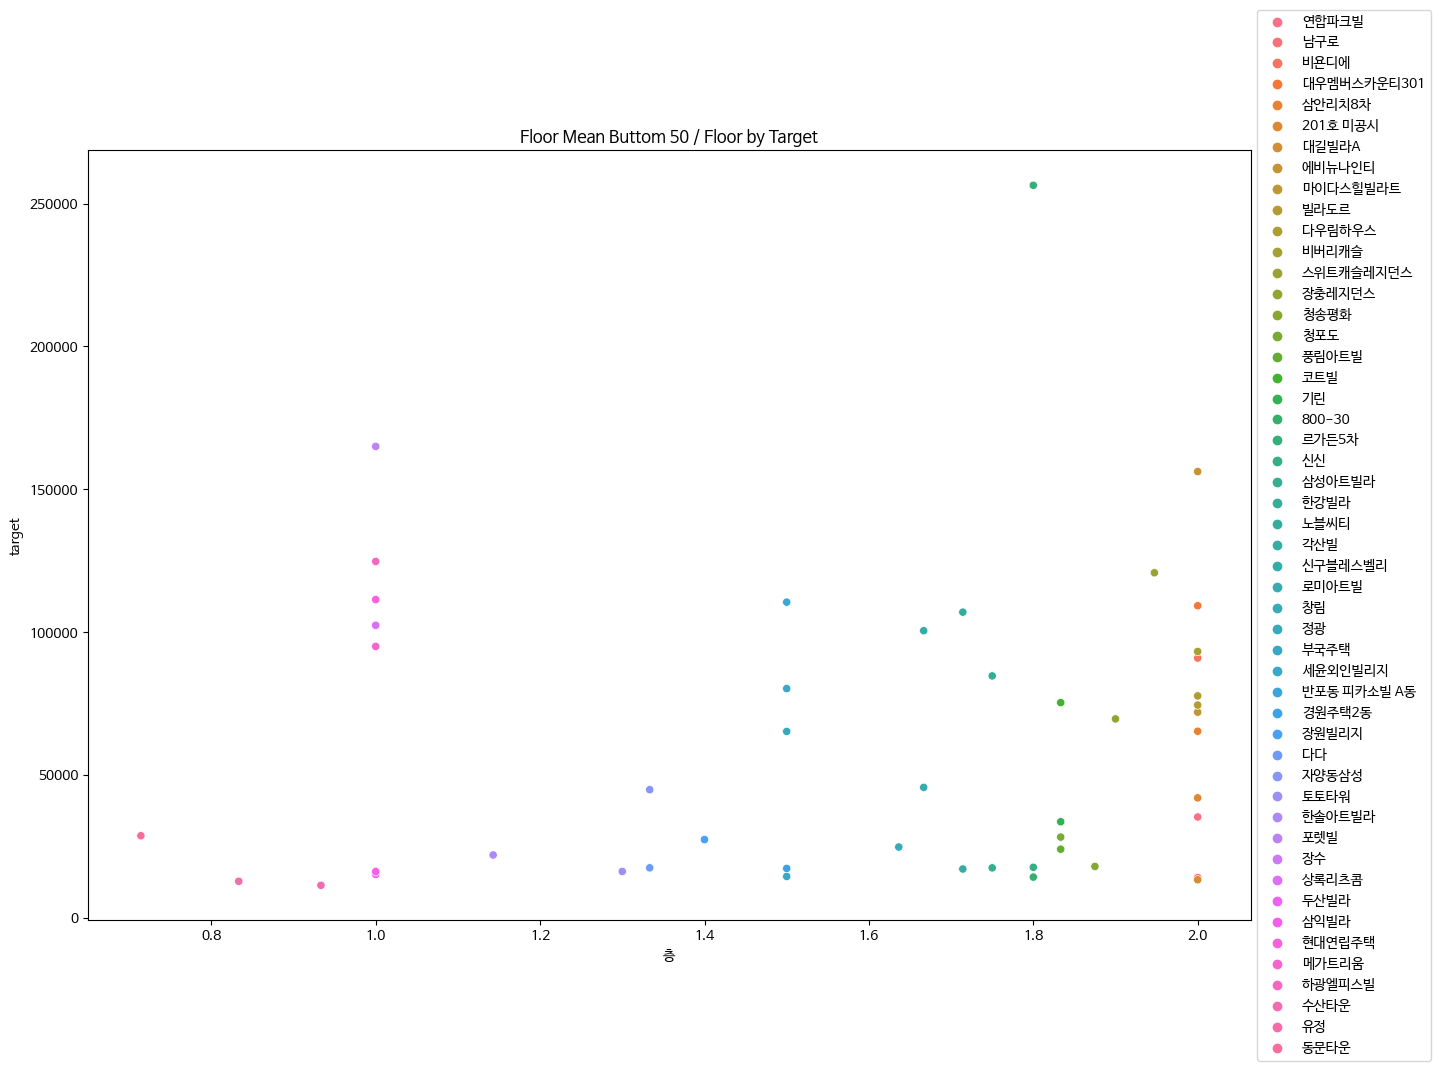

In [13]:
plt.figure(figsize=(15, 10))
plt.title("Floor Mean Buttom 50 / Floor by Target")
floor_scatter = sns.scatterplot(data=floor_mean_buttom50, x="층", y="target", hue=floor_mean_buttom50.index,legend=True)
floor_scatter.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '연합파크빌'),
  Text(1, 0, '남구로'),
  Text(2, 0, '비욘디에'),
  Text(3, 0, '대우멤버스카운티301'),
  Text(4, 0, '삼안리치8차'),
  Text(5, 0, '201호 미공시'),
  Text(6, 0, '대길빌라A'),
  Text(7, 0, '에비뉴나인티'),
  Text(8, 0, '마이다스힐빌라트'),
  Text(9, 0, '빌라도르'),
  Text(10, 0, '다우림하우스'),
  Text(11, 0, '비버리캐슬'),
  Text(12, 0, '스위트캐슬레지던스'),
  Text(13, 0, '장충레지던스'),
  Text(14, 0, '청송평화'),
  Text(15, 0, '청포도'),
  Text(16, 0, '풍림아트빌'),
  Text(17, 0, '코트빌'),
  Text(18, 0, '기린'),
  Text(19, 0, '800-30'),
  Text(20, 0, '르가든5차'),
  Text(21, 0, '신신'),
  Text(22, 0, '삼성아트빌라'),
  Text(23, 0, '한강빌라'),
  Text(24, 0, '노블씨티'),
  Text(25, 0, '각산빌'),
  Text(26, 0, '신구블레스벨리'),
  Text(27, 0, '로미아트빌'),
  Text(28, 0, '창림'),
  Text(29, 0, '정광'),
  Text(30, 0, '부국주택'),
  Text(31, 0, '세윤외인빌리지'),
  Text(32, 0, '반

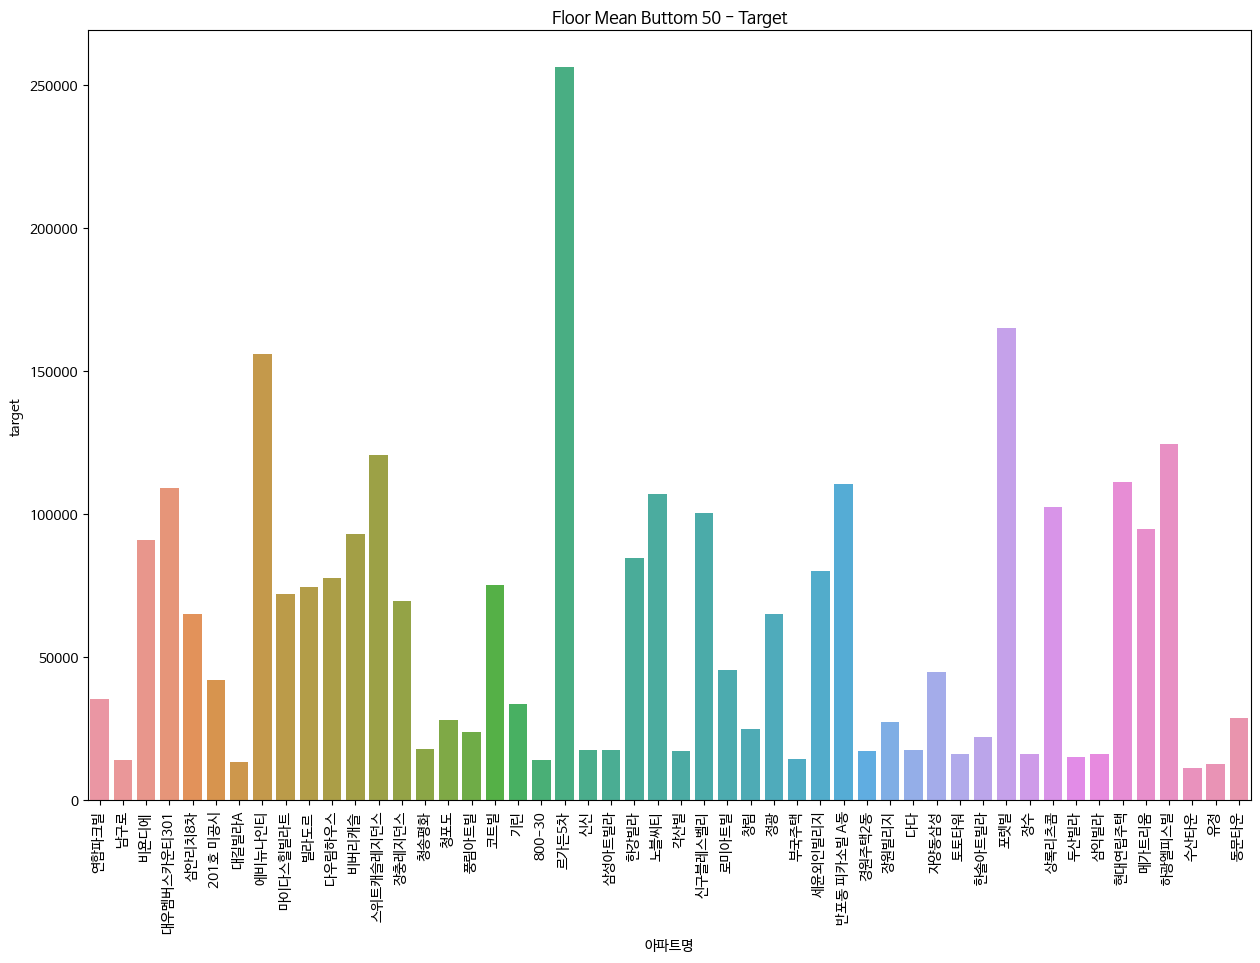

In [14]:
plt.figure(figsize=(15, 10))
plt.title("Floor Mean Buttom 50 - Target")
floor_scatter = sns.barplot(data=floor_mean_buttom50, x=floor_mean_buttom50.index, y="target")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '타워팰리스3'),
  Text(1, 0, '현대하이페리온'),
  Text(2, 0, '타워팰리스1'),
  Text(3, 0, '래미안용산더센트럴'),
  Text(4, 0, '힐스테이트뉴포레'),
  Text(5, 0, '보라매삼성쉐르빌'),
  Text(6, 0, '갤러리아포레'),
  Text(7, 0, '갤러리아팰리스'),
  Text(8, 0, '금천롯데캐슬골드파크3차'),
  Text(9, 0, '타워팰리스2'),
  Text(10, 0, '프레미어스엠코'),
  Text(11, 0, '더샵파크프레스티지'),
  Text(12, 0, '래미안원베일리'),
  Text(13, 0, '트라팰리스웨스턴에비뉴'),
  Text(14, 0, '더샵스타시티'),
  Text(15, 0, '래미안강동팰리스'),
  Text(16, 0, '아크로서울포레스트'),
  Text(17, 0, '트라팰리스이스턴에비뉴'),
  Text(18, 0, 'DMC금호리첸시아'),
  Text(19, 0, '보라매아카데미타워'),
  Text(20, 0, '코업스타클래스'),
  Text(21, 0, '리첸시아'),
  Text(22, 0, '대우메트로디오빌'),
  Text(23, 0, '롯데캐슬프레지던트'),
  Text(24, 0, '래미안첼리투스'),
  Text(25, 0, 'e편한세상독산더타워'),
  Text(26, 0, '용산KCC웰츠타워'),
  Text(27, 0, '잠실푸르지오월드마크'),
  Text(28, 0, '디큐브시티'),
  T

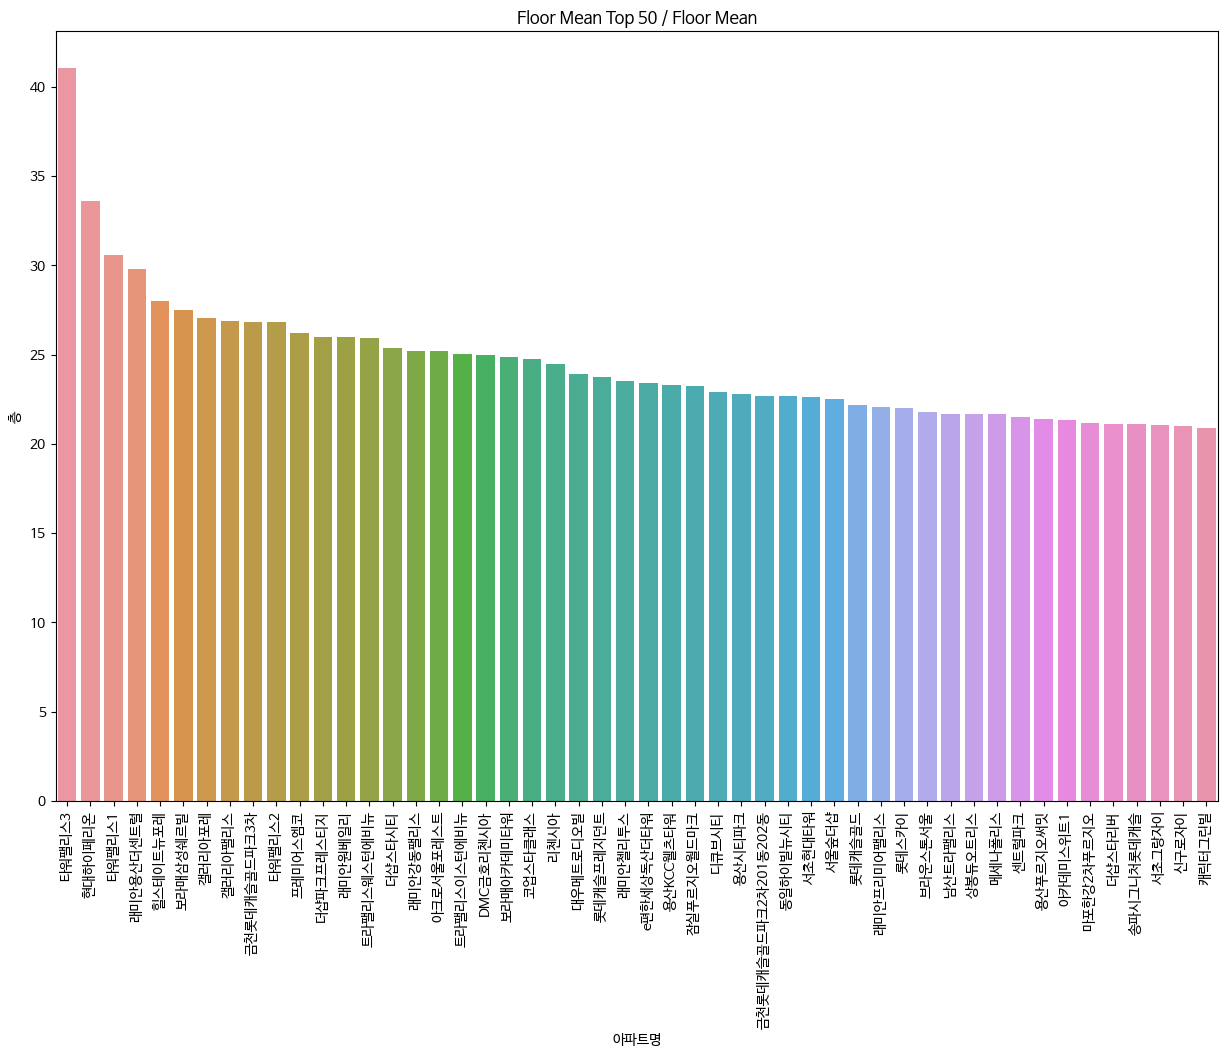

In [15]:
plt.figure(figsize=(15, 10))
plt.title("Floor Mean Top 50 / Floor Mean")
floor_scatter = sns.barplot(data=floor_mean_top50, x=floor_mean_top50.index, y="층")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '연합파크빌'),
  Text(1, 0, '남구로'),
  Text(2, 0, '비욘디에'),
  Text(3, 0, '대우멤버스카운티301'),
  Text(4, 0, '삼안리치8차'),
  Text(5, 0, '201호 미공시'),
  Text(6, 0, '대길빌라A'),
  Text(7, 0, '에비뉴나인티'),
  Text(8, 0, '마이다스힐빌라트'),
  Text(9, 0, '빌라도르'),
  Text(10, 0, '다우림하우스'),
  Text(11, 0, '비버리캐슬'),
  Text(12, 0, '스위트캐슬레지던스'),
  Text(13, 0, '장충레지던스'),
  Text(14, 0, '청송평화'),
  Text(15, 0, '청포도'),
  Text(16, 0, '풍림아트빌'),
  Text(17, 0, '코트빌'),
  Text(18, 0, '기린'),
  Text(19, 0, '800-30'),
  Text(20, 0, '르가든5차'),
  Text(21, 0, '신신'),
  Text(22, 0, '삼성아트빌라'),
  Text(23, 0, '한강빌라'),
  Text(24, 0, '노블씨티'),
  Text(25, 0, '각산빌'),
  Text(26, 0, '신구블레스벨리'),
  Text(27, 0, '로미아트빌'),
  Text(28, 0, '창림'),
  Text(29, 0, '정광'),
  Text(30, 0, '부국주택'),
  Text(31, 0, '세윤외인빌리지'),
  Text(32, 0, '반

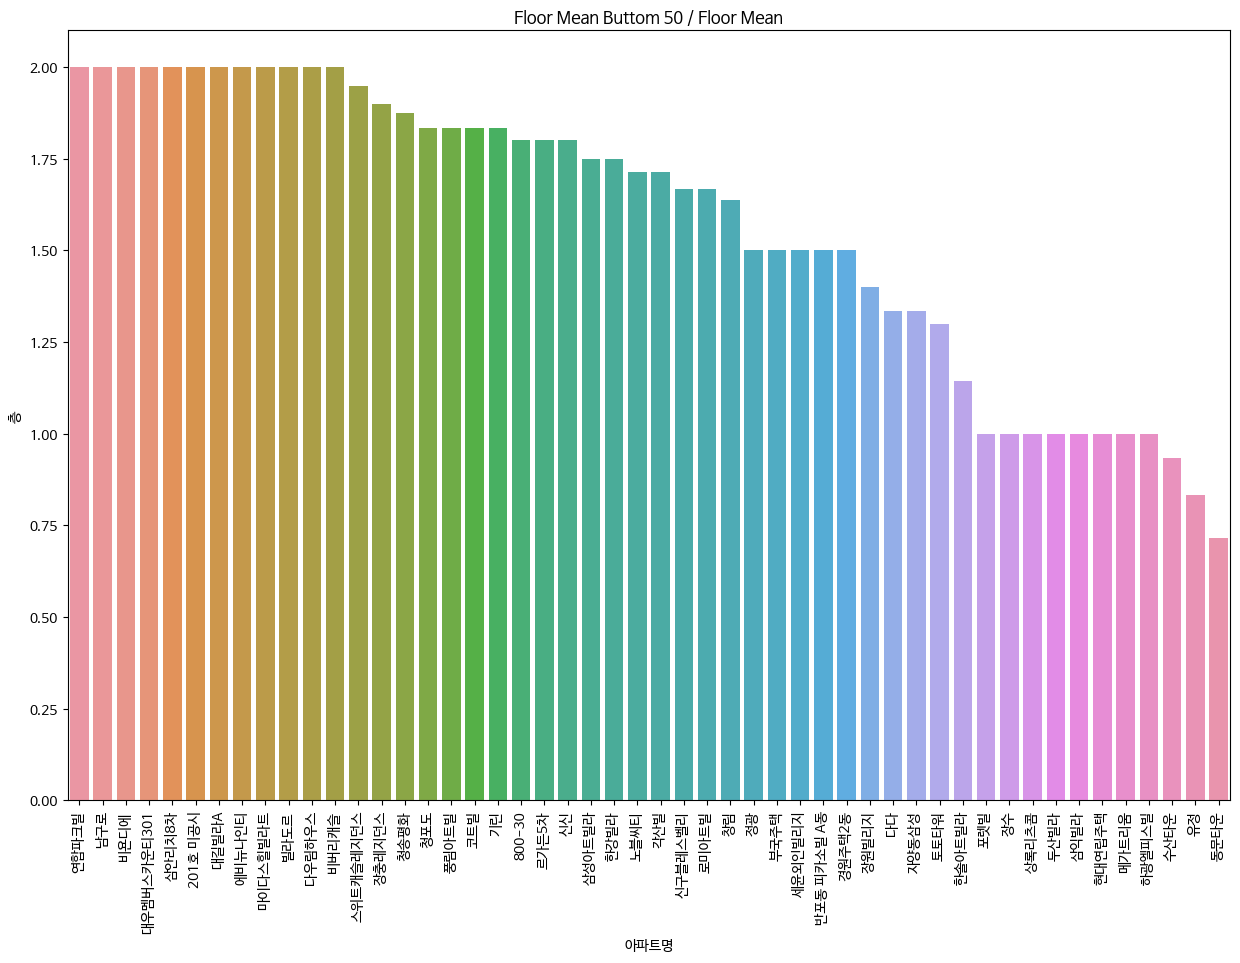

In [16]:
plt.figure(figsize=(15, 10))
plt.title("Floor Mean Buttom 50 / Floor Mean")
floor_scatter = sns.barplot(data=floor_mean_buttom50, x=floor_mean_buttom50.index, y="층",)
plt.xticks(rotation=90)

In [17]:
floor_top50 = train.sort_values(by="층", ascending=False).head(50).reset_index(drop=True)
floor_top50.index = floor_top50.index+1
floor_top50["xlabel"] = floor_top50.index.astype(str) + ". " + floor_top50["아파트명"].astype(str) + "(" + floor_top50["전용면적(㎡)"].astype(str) + "㎡, " + floor_top50["층"].astype(str) + "층)"

In [18]:
floor_top50["xlabel"]

1      1. 현대하이페리온(154.05㎡, 69층)
2      2. 현대하이페리온(167.44㎡, 69층)
3      3. 현대하이페리온(154.05㎡, 68층)
4      4. 타워팰리스3(176.076㎡, 68층)
5      5. 타워팰리스3(185.622㎡, 68층)
6      6. 현대하이페리온(167.44㎡, 68층)
7      7. 현대하이페리온(167.44㎡, 68층)
8      8. 현대하이페리온(154.05㎡, 68층)
9      9. 현대하이페리온(154.05㎡, 67층)
10     10. 현대하이페리온(138.2㎡, 67층)
11     11. 현대하이페리온(138.2㎡, 67층)
12     12. 타워팰리스3(235.74㎡, 67층)
13    13. 현대하이페리온(154.05㎡, 67층)
14    14. 타워팰리스3(163.944㎡, 67층)
15    15. 현대하이페리온(154.05㎡, 66층)
16    16. 현대하이페리온(154.05㎡, 66층)
17    17. 타워팰리스3(185.622㎡, 66층)
18    18. 타워팰리스3(214.967㎡, 66층)
19    19. 타워팰리스3(185.622㎡, 66층)
20    20. 타워팰리스3(176.076㎡, 66층)
21    21. 타워팰리스3(214.967㎡, 66층)
22     22. 타워팰리스1(222.48㎡, 66층)
23    23. 현대하이페리온(167.44㎡, 66층)
24      24. 타워팰리스1(78.99㎡, 66층)
25    25. 타워팰리스3(244.224㎡, 66층)
26     26. 현대하이페리온(138.2㎡, 65층)
27    27. 현대하이페리온(154.05㎡, 65층)
28     28. 현대하이페리온(138.2㎡, 65층)
29    29. 현대하이페리온(154.05㎡, 65층)
30     30. 현대하이페리온(138.2㎡, 65층)
31    31. 타워팰리스3(214.967㎡, 64층)
32    32

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '1. 현대하이페리온(154.05㎡, 69층)'),
  Text(1, 0, '2. 현대하이페리온(167.44㎡, 69층)'),
  Text(2, 0, '3. 현대하이페리온(154.05㎡, 68층)'),
  Text(3, 0, '4. 타워팰리스3(176.076㎡, 68층)'),
  Text(4, 0, '5. 타워팰리스3(185.622㎡, 68층)'),
  Text(5, 0, '6. 현대하이페리온(167.44㎡, 68층)'),
  Text(6, 0, '7. 현대하이페리온(167.44㎡, 68층)'),
  Text(7, 0, '8. 현대하이페리온(154.05㎡, 68층)'),
  Text(8, 0, '9. 현대하이페리온(154.05㎡, 67층)'),
  Text(9, 0, '10. 현대하이페리온(138.2㎡, 67층)'),
  Text(10, 0, '11. 현대하이페리온(138.2㎡, 67층)'),
  Text(11, 0, '12. 타워팰리스3(235.74㎡, 67층)'),
  Text(12, 0, '13. 현대하이페리온(154.05㎡, 67층)'),
  Text(13, 0, '14. 타워팰리스3(163.944㎡, 67층)'),
  Text(14, 0, '15. 현대하이페리온(154.05㎡, 66층)'),
  Text(15, 0, '16. 현대하이페리온(154.05㎡, 66층)'),
  Text(16, 0, '17. 타워팰리스3(185.622㎡, 66층)'),
  Text(17, 0, '18. 타워팰리스3(214.967㎡, 66층)'),
  Te

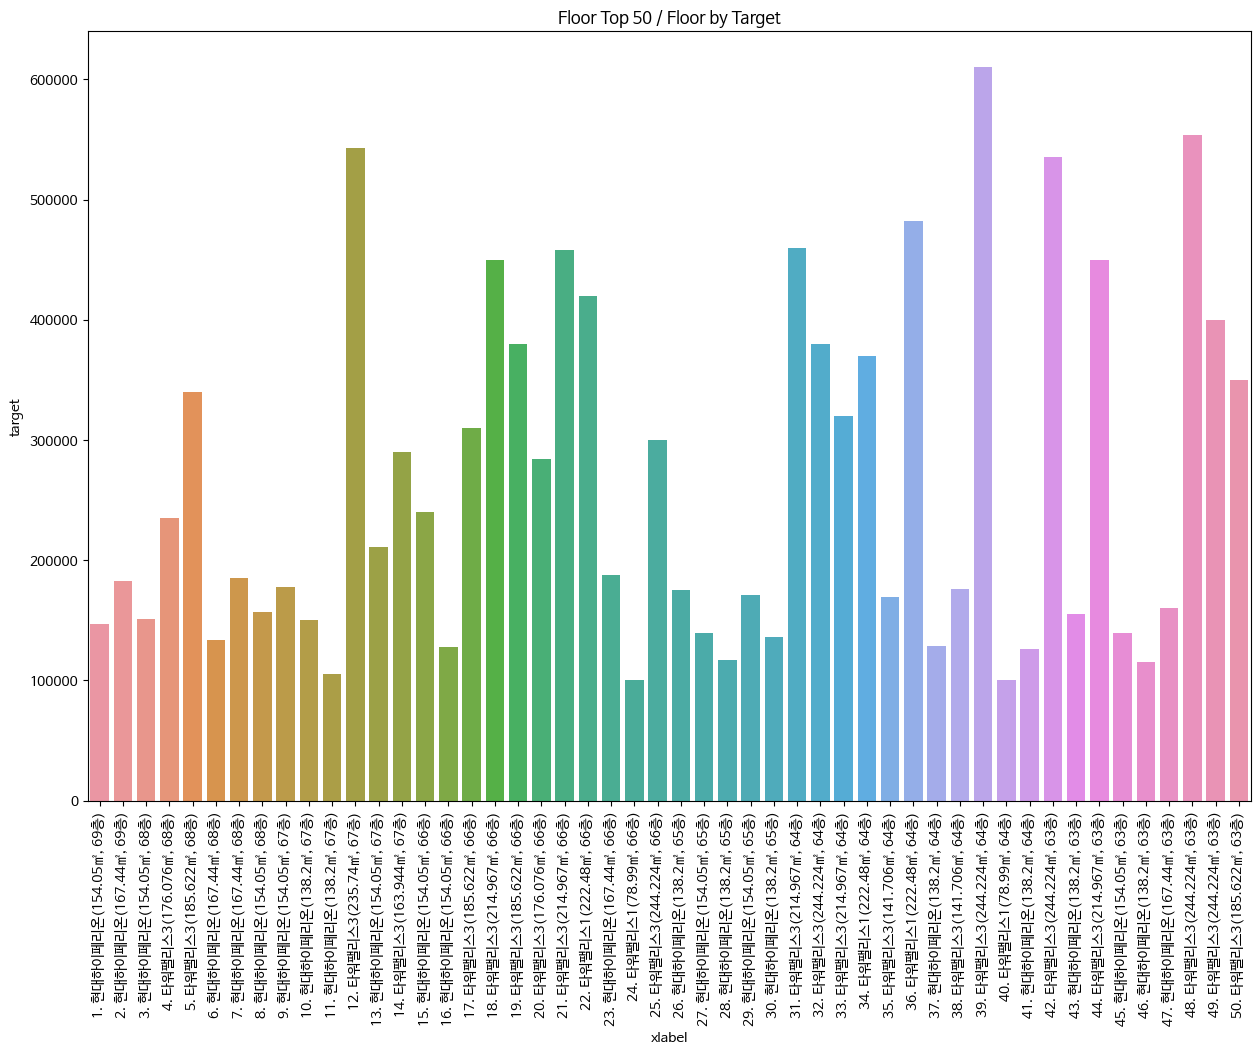

In [19]:
# 데이터 시각화
plt.figure(figsize=(15, 10))
plt.title("Floor Top 50 / Floor by Target")
floor_scatter = sns.barplot(data=floor_top50, x="xlabel", y="target",)
plt.xticks(rotation=90)

In [20]:
floor_buttom50 = train.sort_values(by="층", ascending=False).tail(50).reset_index(drop=True)
floor_buttom50.index = floor_buttom50.index+1
floor_buttom50["xlabel"] = floor_buttom50.index.astype(str) + ". " + floor_buttom50["아파트명"].astype(str) + "(" + floor_buttom50["전용면적(㎡)"].astype(str) + "㎡, " + floor_buttom50["층"].astype(str) + "층)"

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '1. 신신(53.88㎡, -1층)'),
  Text(1, 0, '2. 동문타운(59.56㎡, -1층)'),
  Text(2, 0, '3. 한남더힐(240.23㎡, -1층)'),
  Text(3, 0, '4. 밀레니엄(59.74㎡, -1층)'),
  Text(4, 0, '5. 동은노보빌(95.185㎡, -1층)'),
  Text(5, 0, '6. 천왕연지타운2단지(84.78㎡, -2층)'),
  Text(6, 0, '7. 한남더힐(240.305㎡, -2층)'),
  Text(7, 0, '8. 옥수파크힐스101동~116동(76.66㎡, -2층)'),
  Text(8, 0, '9. 우물골2단지두산위브BL2-7(134.48㎡, -2층)'),
  Text(9, 0, '10. 옥수파크힐스101동~116동(107.99㎡, -2층)'),
  Text(10, 0, '11. 천왕연지타운2단지(84.71㎡, -2층)'),
  Text(11, 0, '12. 한남더힐(240.23㎡, -2층)'),
  Text(12, 0, '13. 옥수파크힐스101동~116동(76.66㎡, -2층)'),
  Text(13, 0, '14. 우물골2단지두산위브BL2-7(134.71㎡, -2층)'),
  Text(14, 0, '15. 옥수파크힐스101동~116동(107.99㎡, -2층)'),
  Text(15, 0, '16. 우물골2단지두산위브BL2-7(167.75㎡, -2층)'),
  Text(16, 0, '17. 우물골2단지두산위브BL2-7(134.71㎡, -2층)'),
  Tex

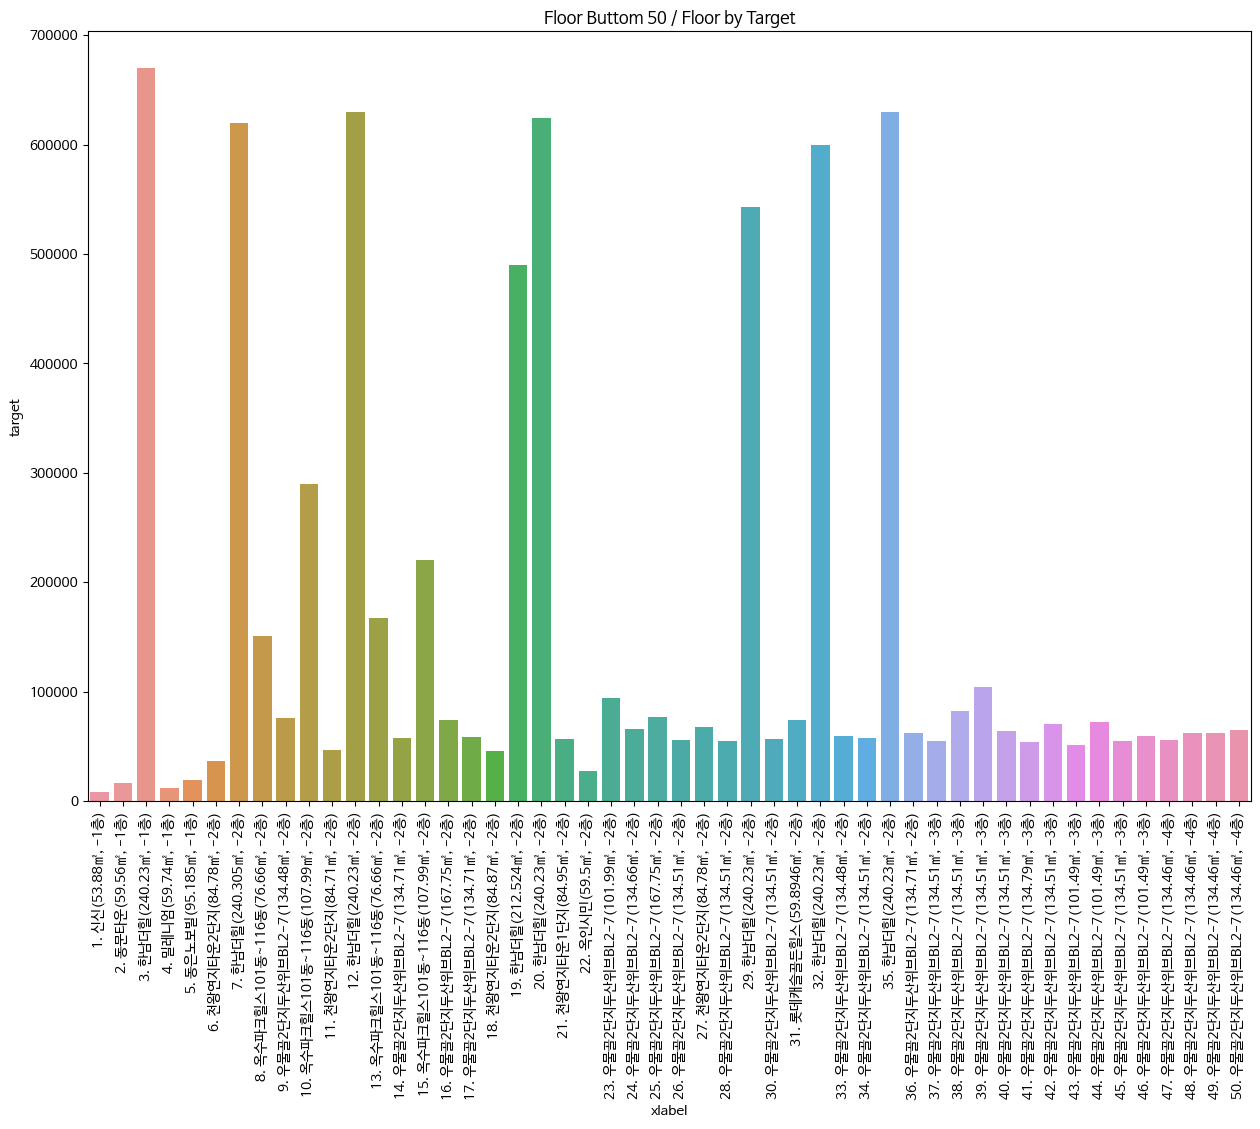

In [21]:
# 데이터 시각화
plt.figure(figsize=(15, 10))
plt.title("Floor Buttom 50 / Floor by Target")
floor_scatter = sns.barplot(data=floor_buttom50, x="xlabel", y="target",)
plt.xticks(rotation=90)

In [22]:
floor = train.groupby(by="층")["target"].mean()

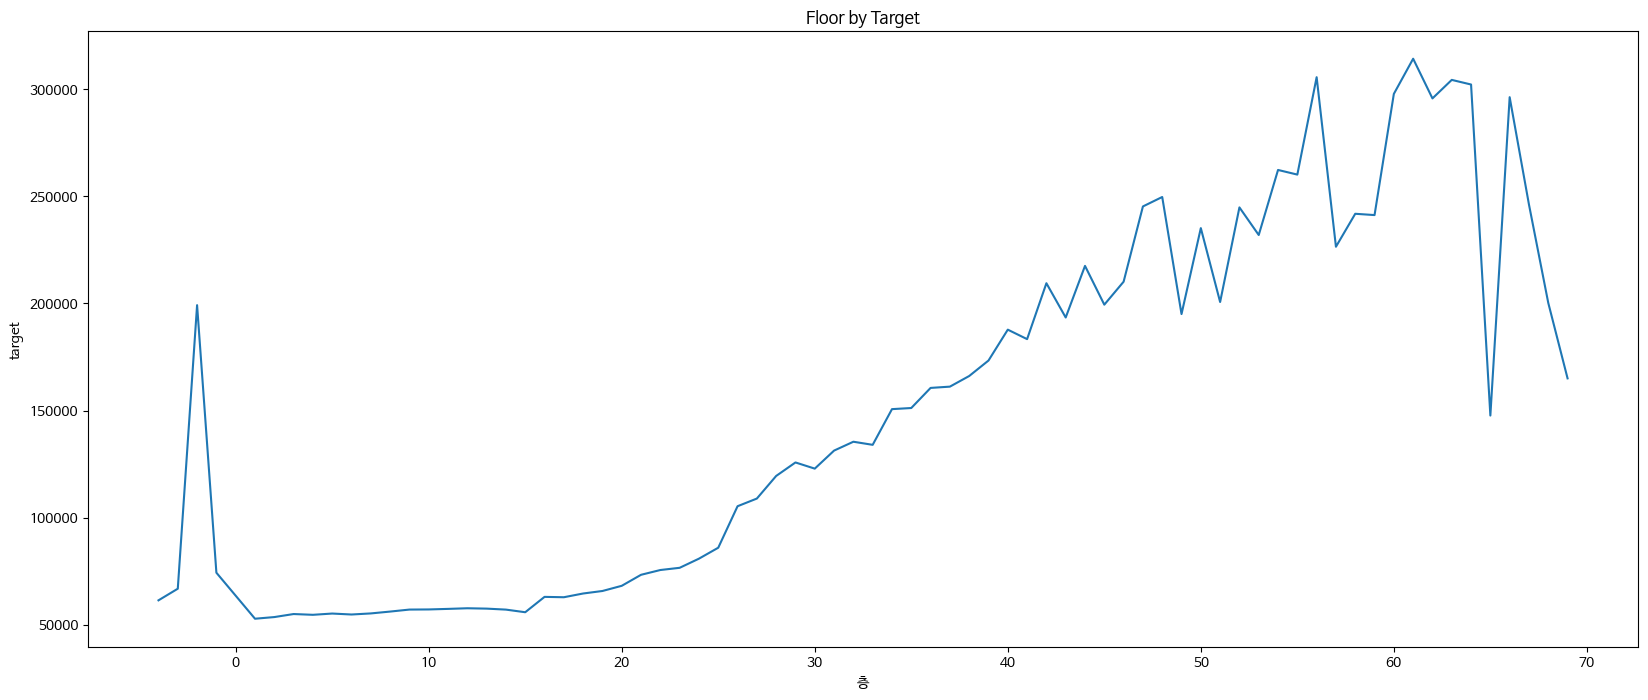

In [23]:
# 데이터 시각화
plt.figure(figsize=(20, 8))
plt.title("Floor by Target")
floor_scatter = sns.lineplot(x=floor.index, y=floor,)
# plt.xticks(rotation=90)

In [25]:
target_top50 = train.sort_values(by="target", ascending=False).head(50).reset_index(drop=True)
target_top50.index = target_top50.index+1
target_top50["xlabel"] = target_top50.index.astype(str) + ". " + target_top50["아파트명"].astype(str) + "(" + target_top50["전용면적(㎡)"].astype(str) + "㎡, " + target_top50["층"].astype(str) + "층)"

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, '1. PH129(273.96㎡, 16층)'),
  Text(1, 0, '2. 파르크한남(268.67㎡, 5층)'),
  Text(2, 0, '3. 아크로서울포레스트(264.546㎡, 47층)'),
  Text(3, 0, '4. 파르크한남(268.95㎡, 2층)'),
  Text(4, 0, '5. 파르크한남(268.67㎡, 4층)'),
  Text(5, 0, '6. PH129(273.96㎡, 14층)'),
  Text(6, 0, '7. 파르크한남(268.95㎡, 3층)'),
  Text(7, 0, '8. 한남더힐(240.305㎡, 3층)'),
  Text(8, 0, '9. 한남더힐(240.305㎡, 5층)'),
  Text(9, 0, '10. 파르크한남(268.67㎡, 2층)'),
  Text(10, 0, '11. 아이파크(203.121㎡, 30층)'),
  Text(11, 0, '12. PH129(273.96㎡, 6층)'),
  Text(12, 0, '13. 파르크한남(268.67㎡, 3층)'),
  Text(13, 0, '14. 르가든더메인한남(228.34㎡, 6층)'),
  Text(14, 0, '15. 나인원한남(206.8953㎡, 8층)'),
  Text(15, 0, '16. PH129(273.96㎡, 10층)'),
  Text(16, 0, '17. 나인원한남(206.8953㎡, 6층)'),
  Text(17, 0, 

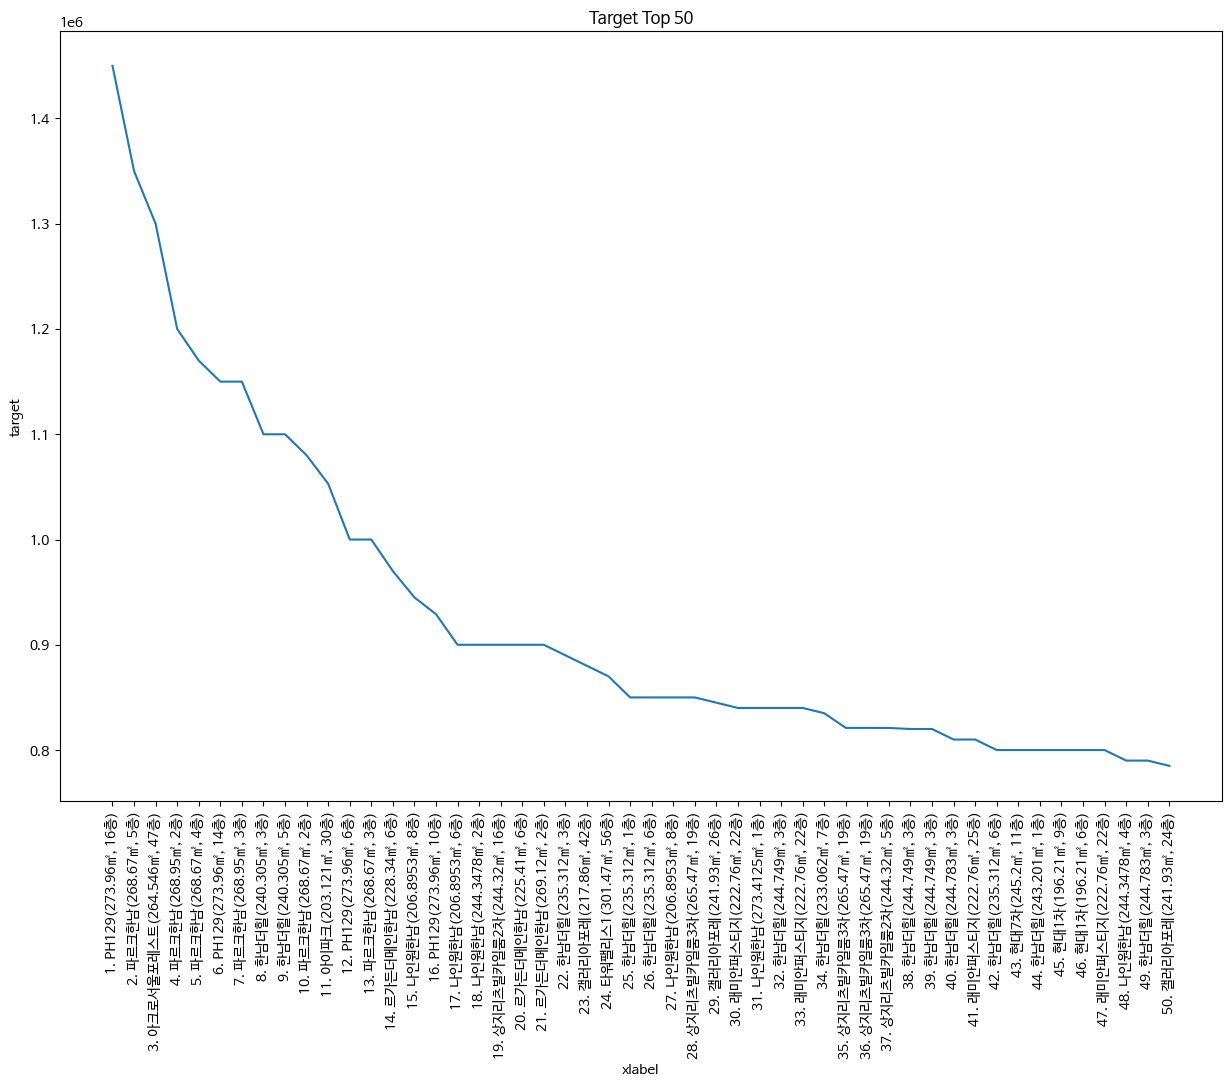

In [26]:
# 데이터 시각화
plt.figure(figsize=(15, 10))
plt.title("Target Top 50")
floor_scatter = sns.lineplot(data=target_top50, x="xlabel", y="target",)
plt.xticks(rotation=90)

In [ ]:
# PH129, 파르크한남, 아크로서울포레스트, 한남더힐, 아이파크, 르가든더메인한남, 나인원한남, 상지리츠빌카일룸2차, 갤러리아포레, 타워팰리스1, 상지리츠빌카일룸3차, 래미안퍼스티지, 현대7차, 현대1차

In [27]:
target_buttom50 = train.sort_values(by="target", ascending=False).tail(50).reset_index(drop=True)
target_buttom50.index = target_buttom50.index+1
target_buttom50["xlabel"] = target_buttom50.index.astype(str) + ". " + target_buttom50["아파트명"].astype(str) + "(" + target_buttom50["전용면적(㎡)"].astype(str) + "㎡, " + target_buttom50["층"].astype(str) + "층)"

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, '1. 새솔금호(59.9㎡, 21층)'),
  Text(1, 0, '2. nan(23.74㎡, 3층)'),
  Text(2, 0, '3. 압구정화이트빌(84.87㎡, 4층)'),
  Text(3, 0, '4. 조성빌라(21.96㎡, 3층)'),
  Text(4, 0, '5. 조성빌라(21.96㎡, 5층)'),
  Text(5, 0, '6. 북아현경남(84.91㎡, 1층)'),
  Text(6, 0, '7. 조성빌라(21.96㎡, 4층)'),
  Text(7, 0, '8. nan(21.92㎡, 1층)'),
  Text(8, 0, '9. nan(26.54㎡, 1층)'),
  Text(9, 0, '10. 교수(46.64㎡, 7층)'),
  Text(10, 0, '11. nan(55.72㎡, 1층)'),
  Text(11, 0, '12. 태헌(56.97㎡, 7층)'),
  Text(12, 0, '13. 은하(16.53㎡, 5층)'),
  Text(13, 0, '14. 구현대(87.83㎡, 2층)'),
  Text(14, 0, '15. 현대빌라(170.28㎡, 7층)'),
  Text(15, 0, '16. 목동미소래(84.95㎡, 8층)'),
  Text(16, 0, '17. 화곡동복지(53.94㎡, 1층)'),
  Text(17, 0, '18. 용산동(51.27㎡, 2층)'),
  Text(18, 0, '19. 풍림1(80.52㎡, 5층)'),
  Text(19, 0, '20. 서울숲대림(84.015㎡, 11층)'),
  Text(20, 0, '2

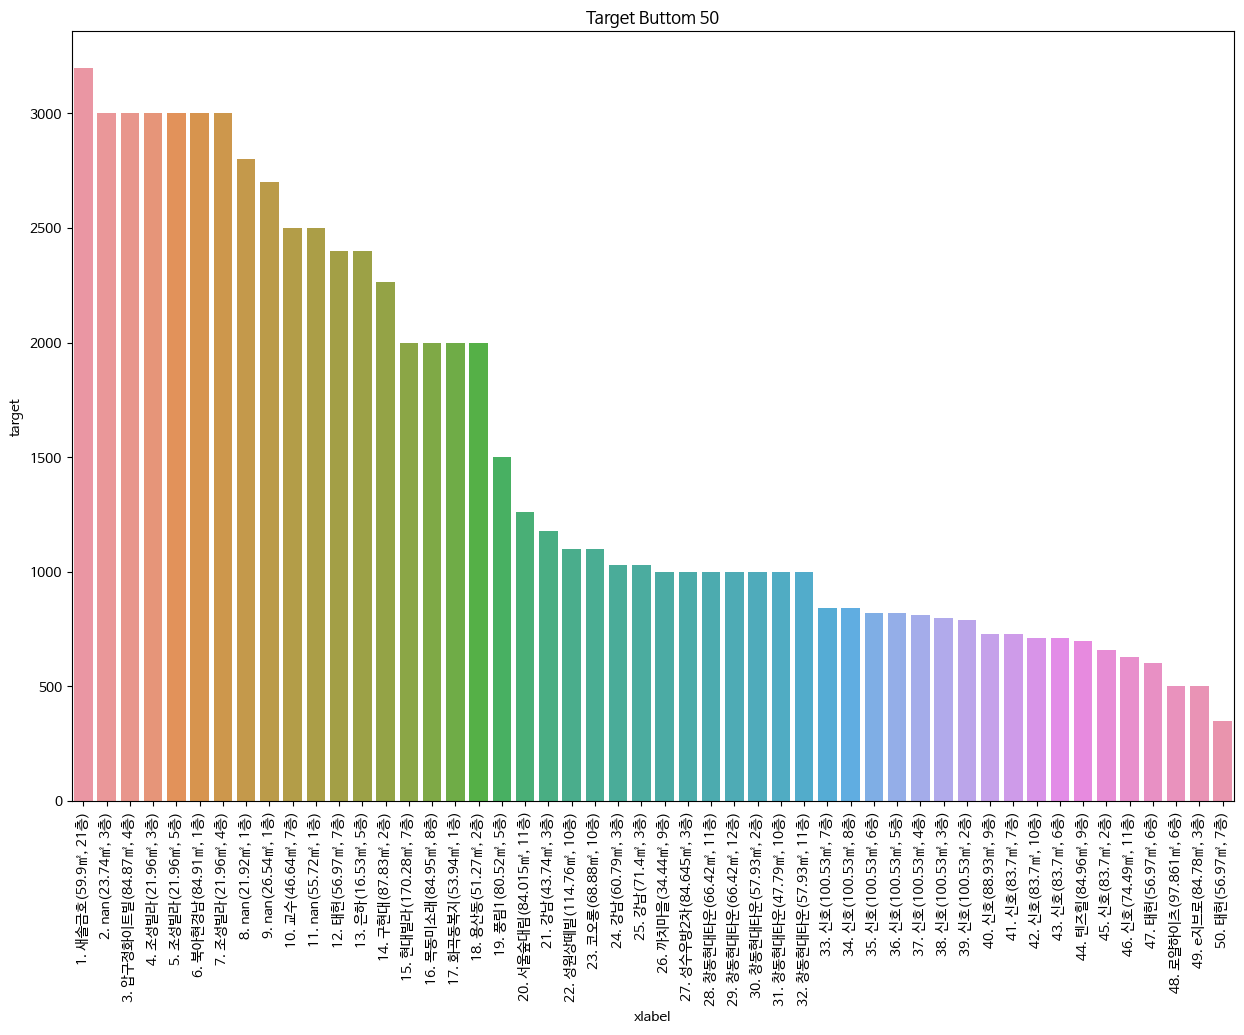

In [28]:
# 데이터 시각화
plt.figure(figsize=(15, 10))
plt.title("Target Buttom 50")
floor_scatter = sns.barplot(data=target_buttom50, x="xlabel", y="target",)
plt.xticks(rotation=90)

In [28]:
target_top50 = train.sort_values(by="target", ascending=False).head(50).reset_index(drop=True)["아파트명"]


In [29]:
target_top50_by_apart = train[train["아파트명"].isin(target_top50.unique())].groupby("아파트명")["target"].mean()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'PH129'),
  Text(1, 0, '갤러리아포레'),
  Text(2, 0, '나인원한남'),
  Text(3, 0, '래미안퍼스티지'),
  Text(4, 0, '르가든더메인한남'),
  Text(5, 0, '상지리츠빌카일룸2차'),
  Text(6, 0, '상지리츠빌카일룸3차'),
  Text(7, 0, '아이파크'),
  Text(8, 0, '아크로서울포레스트'),
  Text(9, 0, '타워팰리스1'),
  Text(10, 0, '파르크한남'),
  Text(11, 0, '한남더힐'),
  Text(12, 0, '현대1차'),
  Text(13, 0, '현대7차')])

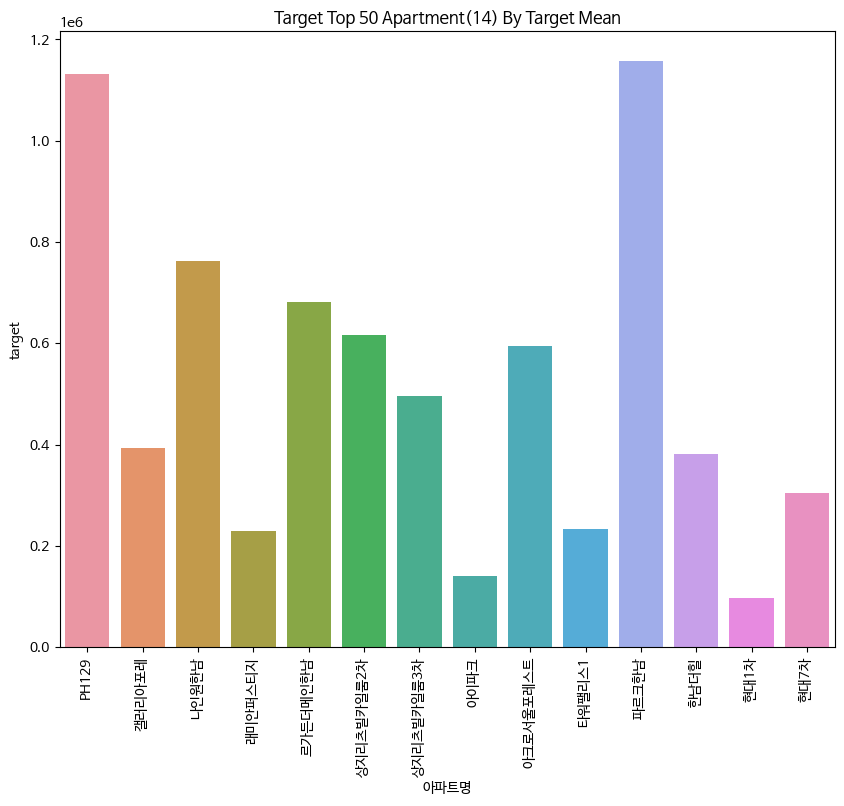

In [31]:
# 데이터 시각화
plt.figure(figsize=(10, 8))
plt.title("Target Top 50 Apartment(14) By Target Mean")
floor_scatter = sns.barplot(x=target_top50_by_apart.index, y=target_top50_by_apart)
plt.xticks(rotation=90)

In [ ]:
# PH129, 파르크한남, 아크로서울포레스트, 한남더힐, 아이파크, 르가든더메인한남, 나인원한남, 상지리츠빌카일룸2차, 갤러리아포레, 타워팰리스1, 상지리츠빌카일룸3차, 래미안퍼스티지, 현대7차, 현대1차

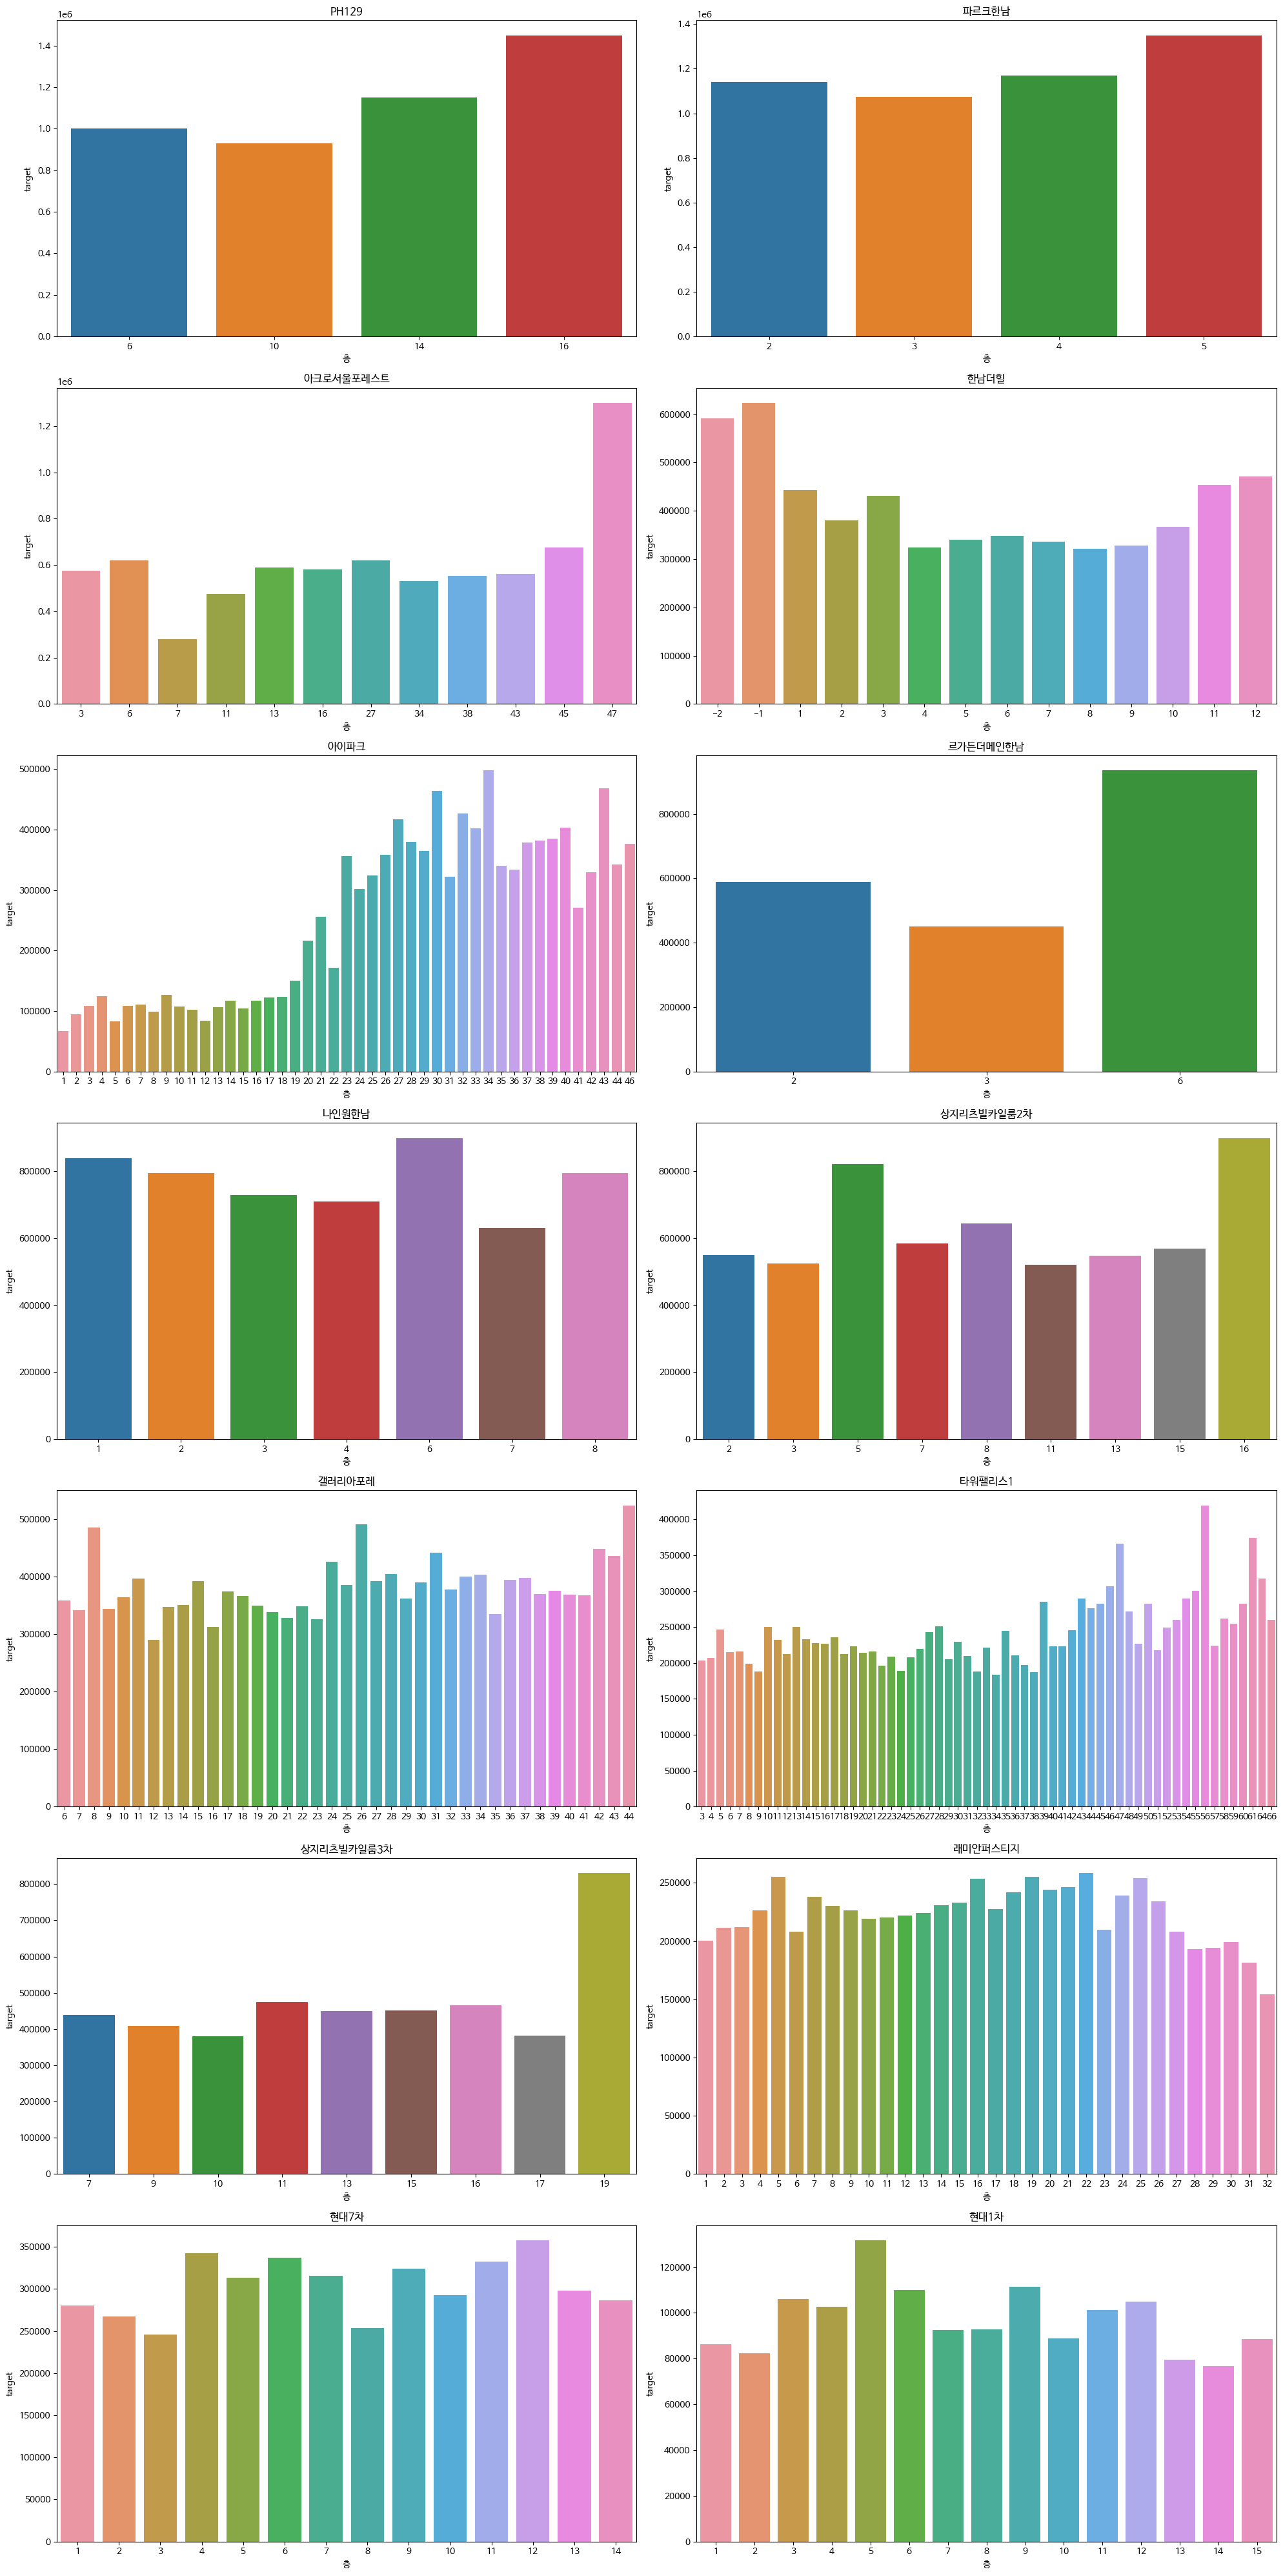

In [36]:
plt.figure(figsize=(20, 40))
for i, apart in enumerate(target_top50.unique()):
    plt.subplot(len(target_top50.unique())//2, 2, i+1)
    plt.title(f"{apart}")
    sns.barplot(x=train[train["아파트명"]==apart].groupby(by="층")["target"].mean().index, y=train[train["아파트명"]==apart].groupby(by="층")["target"].mean())
plt.tight_layout()

In [42]:
target_buttom50 = train[~train["아파트명"].isna()].sort_values(by="target", ascending=False).tail(50).reset_index(drop=True)["아파트명"]

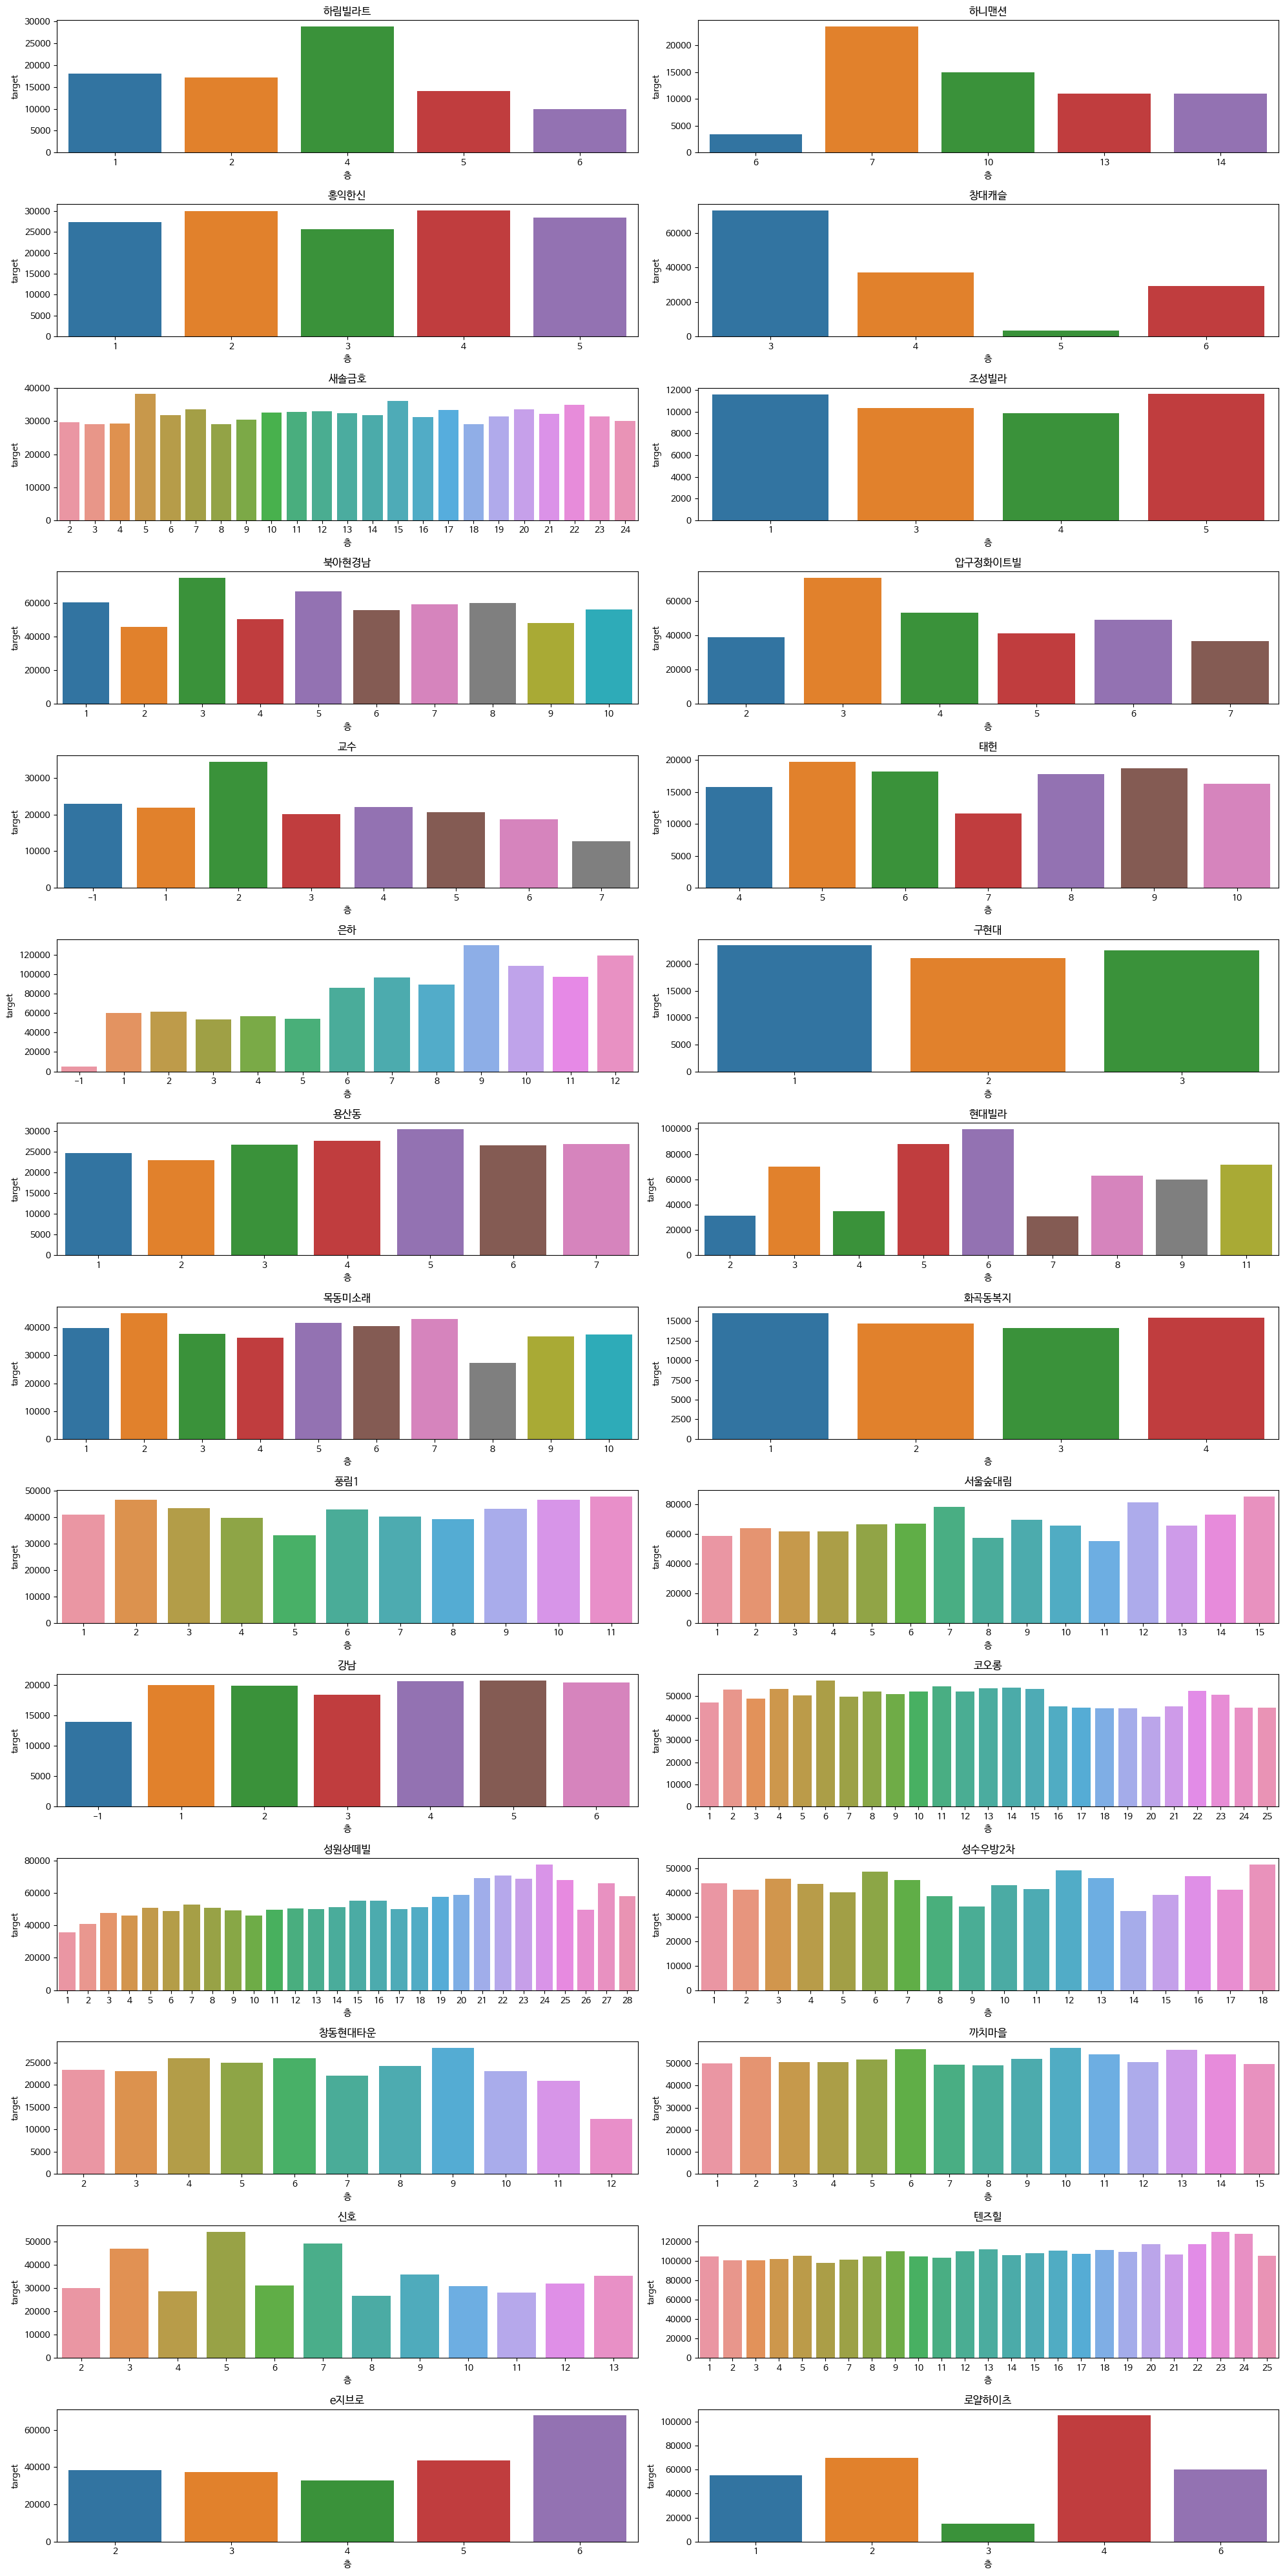

In [45]:
plt.figure(figsize=(20, 40))
for i, apart in enumerate(target_buttom50.unique()):
    plt.subplot(len(target_buttom50.unique())//2, 2, i+1)
    plt.title(f"{apart}")
    sns.barplot(x=train[train["아파트명"]==apart].groupby(by="층")["target"].mean().index, y=train[train["아파트명"]==apart].groupby(by="층")["target"].mean())
plt.tight_layout()